# 09 - Non Compliance and LATE

## Dipping our Toes into a Heterogeneous World

Previously, we've seen Instrumental Variables through a more traditional lens. IV was seen as some sort of natural experiment we can leverage. In contrast, modern IV practice draws a lot of insight from medical sciences. It partitions the world into 4 kinds of subjects, depending on how they respond to the instrumental variable.

1. Compliers
2. Never Takers
3. Always Takers
4. Defiers

This naming comes from pharmaceutical science. Imagine you are conducting an experiment to test the effect of a new drug on some illness. Each subject gets assigned to a treatment: a drug or a placebo. The compliers are the subjects that stick to what was assigned to them. If they get the placebo, they take it; if they get the drug, they also take it. The never takers are those subjects that refuse to take their medicine. Even if they are assigned the new drug, they won't take it. On the other hand, the always takers are those that can somehow get the new drug even if they were assigned to the placebo. Finally, Defiers are the ones that take the treatment if assigned to the control and take the control if assigned the treatment. You can think of them as that annoying child that does the opposite of what it is told. In practice, they are not so common (the defiers, not the kids), so we will often ignore them.

![img](./data/img/late/defiers.png)

Modern IV treats the instrument as a quasi-experimental design where compliance is not perfect. By doing so, it distinguishes internally from externally valid causal effects. Just as a reminder, an internally valid effect is one we are able to identify. It is valid in that particular setting, with that particular data. In IV, it would be the treatment effect on those where the instrument changes the treatment. External validity, on the other hand, would be concerned with the predictive power of that causal effect. It would ask the question of whether we could generalize the effect we found in this sample for other populations. For example, let's say you conducted an RCT in your university to figure out if people are generous or not, when given an incentive to donate. The experiment is well designed, but you only invite economics students to participate. You then find that all of them are selfish jerks. This is an internally valid conclusion. It's valid for those data points. But can you, from that experiment, infer that humanity is selfish? That's hardly the case. So we would question whether your experiment has external validity to generalize its results. Anyway, back to IV.

To make it more concrete, let's consider a case where you want to boost user engagement measured by in app purchase. One way to do that, is by asking your marketing department to come up with a push you can use to engage your users. They come up with a brilliant design and very fancy user interactions. With that push, you move on to design a randomised trial. You select 10000 random customers and, for each of them, you assign the push with 50% probability. However, when you execute the test, you notice that some customers who were assigned to receive the push are not receiving it. When you talk to the engineers, they say that it is because they probably have an older phone that doesn't support the kind of push the marketing team designed. 

At first, you might think that this is no big deal. Instead of using treatment assigned as your treatment variable, you can just use the treatment received, right? It turns out it is not that simple. If you plot the causal graph of this whole situation, it would look something like this:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

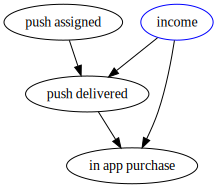

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

Up on the causal graph, you have the push assignment. This is random by design, so nothing is causing it. Then, you have a node for if the push was delivered. Not everyone that was assigned to receive the push did it, so you have non compliance here. More specifically, you have some never takers: those that don't receive the treatment even if assigned to it. You also have reasons to suspect that this non compliance is not simply by chance. Since people with older phones are the ones that don't get the push, you can argue that income is also causing push delivery. The richer the person, the more likely it is that he or she has a nicer phone, which in turn makes it more likely that he or she will receive the push. Finally, you have the outcome variable, in app purchase. Keep in mind that we don't know income, so we can't control it. With this in mind, let's examine what would happen if we simply used the push assigned as the treatment variable and if instead we used push delivered as the treatment. 

In the first case, we would estimate the causal effect by the following difference in means:

$
ATE = E[Y | pushAssigned=1] - E[Y | pushAssigned=0]
$

As we are very aware by now, this is only unbiased estimate for $E[Y_1] - E[Y_0]$ if the bias $E[Y_0|pushAssigned=0] - E[Y_0|pushAssigned=1]$ is zero. Since `pushAssigned` is random, we know that the bias is zero. Does this settle it then? Not quite. You see, if we do this, we are actually answering a different question than the one we intended to. We would be finding the **causal effect of treatment assignment**, not of the treatment itself. But are they different or can we extrapolate the causal effect of treatment assignment to the ATE? In other words, is the causal effect of treatment assignment an unbiased estimate of the ATE? 

As it turns out, it is not. Because of non compliance, the outcome of those assigned to the treatment will be pushed in the direction of the outcome of those assigned to the control. Non compliance flips the treatment unintendedly, making the treatment and control more similar in the outcome. Don't confuse this with similarity on the variables. We want treated and control to be similar on the variables. That will make them comparable. What we don't want is for them to be similar in the outcome if there is indeed a treatment effect.

To see this, suppose first we have always takers. Some of them will be assigned to the control by chance. But those that are, will take the treatment anyway. This makes them essentially a treated group that is mixed up with the control. As a result of this mix, the causal effect will be harder to find when we have non compliance.

![img](./data/img/late/always_takers.png)

By the same reasoning, never takers will make those assigned to the treatment look a little bit like the untreated, because they don't take the treatment even if assigned to it. In this sense, **the causal effect of treatment assignment is biased towards zero** because non compliance shrinks the detectable impact. Another way to see this is to imagine an extreme case. Let's say that non compliance is really high. Treatment assignment says nothing about treatment received. Treatment received is purely random in this case. In IV language, that would be saying we have a very weak 1st stage. Using `Z` to denote the treatment assignment, we would have that

$
E[Y|Z=1] - E[Y|Z=0] = 0
$

There would be no more causal link of treatment assignment to the outcome. Z would be just a meaningless random variable floating there. 

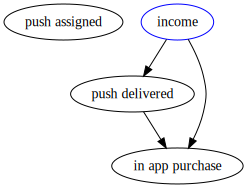

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

OK, so we've ruled out using the causal effect of the assignment as a way to estimate the causal effect of the treatment. So, how about just using the treatment received? 

$
ATE = E[Y | push=1] - E[Y | push=0]
$

Once again, we need to think if this is biased or not, or if $E[Y_0|push=0] = E[Y_0|push=1]$. Just by looking at the causal graph above, we know it is not the case. We have that unmeasured confounder, income, lurking around, and it is sure to mess things up. As we've said earlier, we know that failure in push delivery, in our case, is caused by customers having older phones. Which means that we probably have  $E[Y_0|push=0] < E[Y_0|push=1]$. We think this is the case because customers with less money both have older phones which will lead to $push=0$ and also a lower potential in app purchase $Y_0$. 

Bummer! We can't use treatment assigned nor treatment received to estimate our ATE. But fortunately, we know what we can use: Instrumental Variables. Here, treatment assigned is the perfect instrument for the treatment. It is as good as random and it only causes in-app purchase by the virtue of the treatment.

## Local Average Treatment Effect: LATE

Local average treatment effect makes it explicit the population for which we can estimate the causal effect. It is also another way to view IV, which gives other cool intuitions we can use. In modern IV, we see the instrument as starting a causal chain: Z causes T which causes Y. In this context, the exclusion restriction means that Z does not cause Y, unless by its effect on T. The 1st stage is now viewed as the causal effect of Z on T. We also rewrite potential outcomes with a double indexing notation, where the first index denotes the counterfactual for the instrument and the second index, for the treatment

$
\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}
$

In a sense, the treatment becomes the outcome, at least in the first stage. This means we can also write it with potential outcome notation:

$
\text{Potential Treatment}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}
$

![img](./data/img/late/double_index.png)

Instrumental Variable assumptions can now be rewritten as follows

1. $T_{0i}, T_{1i} \perp Z_i $ and $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i $. This is the independence Assumption. This says that the instrument is as good as randomly assigned. In other words, Z, the instrument, is not correlated with the potential treatments, which is the same as saying that people in different instrument groups are comparable. 

2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$ and $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$. This is the exclusion restriction. It says that if I'm looking at the potential outcome for the treated, it is the same for both instrument groups. In other words, the instrument does not affect the potential outcome, which is the same as saying that the instrument only affects the outcome through the treatment.

3. $E[T_{1i}-T_{0i}] \neq 0$. This is the existence of a 1st stage. It is saying that the potential outcome of the 1st stage, that is, the potential treatment, is NOT the same. Another way of saying this is that the instrument does affect the treatment.

4. $T_{i1} > T_{i0}$. This is the monotonicity assumption. It is saying that if everyone had the instrument turned on, the treatment level would be higher than if everyone had the treatment turned off. 

Now, let's review the Wald estimator to gain some further intuition on IV:

$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

Let's take the first bit of it, $E[Y|Z=1]$. Using the exclusion restriction, we can rewrite Y in terms of potential outcome like this.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$

Using independence, we can take out the conditioning on Z.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$

With a similar argument, we get that

$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$

We can now rewrite the numerator of the Wald estimator like this

$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$

Using monotonicity, we know that $T_{i1}-T_{i0}$ is 0 or 1, so

$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})
$

Using a similar argument to tackle the denominator, we get that

$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$

All of this allows us to look at the Wald estimator like this:

$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$

That is, the ATE as estimated by IV is the ATE on the subpopulation where $T_{i1}>T_{i0}$. And if you think about compliance, which population is this? This is the population where those that get the instrument turned on have the treatment level higher than if they had the instrument turned off. In other words, this is the compiler population. Just so we can remember,

1. Compilers means that $T_{i1}>T_{i0}$
2. Never Takers $T_{i1}=T_{i0}=0$
3. Always Takers $T_{i1}=T_{i0}=1$

The conclusion of this is that IV says nothing about the effect on never takers, always takers or defiers, because the treatment is unchanged for them! **IV only finds the treatment effect for the compliers**.

## Effect on Engagement

Let's see how all of this plays out in the case study where we try to estimate the effect of a push on in-app purchase. The causal graph is the one we depicted above, so I won't repeat it here. The data we have is on both push assigned, the randomised instrument, and push delivered, the treatment variable.

In [9]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


First, let's run OLS to see what it would give us.

In [10]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


OLS is saying that the treatment effect is BRL 27.60, that is, the push increases in-app purchase by 27.6 reais. However, we have reasons to believe this is a biased estimate. We know that older phones are having trouble in receiving the push, so, probably, richer customers, with newer phones, are the compilers. Since the ones that get the treatment also have more money, we believe this bias is positive and the true impact of the push is lower. In other words, we probably have $E[Y_0|T=0] < E[Y_0|T=1]$.

Now, let's try to estimate this effect with Instrumental Variables. First, let's run the first stage.

In [11]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,7.408e-11,0.0000,1.0000,-1.452e-10,1.452e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


Looks like we have a strong first stage. Those that get assigned to get the push get it 71.8% of the time. This means that we have something like 28% of never takers. We also have strong reasons to believe there are no always takers, since the intercept parameter is estimated to be zero. This means that no one get's the push if it is not assigned to it. Given the design of our experiment, this is expected. 

Let's now run the reduced form:

In [7]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


The reduced form shows that the causal effect of treatment assignment is 2.36. This means that assigning someone to receive the push increases the in-app purchase by 2.36 reais. 

If we divide the reduced form by the first stage, we scale the effect of the instrument by the units of the treatment, we get $2.3636/0.7176=3.29$. Running the 2SLS, we get these same estimates, with the bonus of correct standard errors.

In [8]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


This shows that the result with 2SLS is much lower than the one we got with OLS: 3.29 against 27.60. This makes sense, since the causal effect estimated with OLS is positively biased. We also need to remember about LATE. 3.29 is the average causal effect on compliers. Unfortunately, we can't say anything about those never takers. This means that we are estimating the effect on the richer segment of the population that have newer phones.

## Key Ideas

Here we've looked at a more modern view of Instrumental Variables. We saw how IV can be seen as a causal chain where the instrument causes the treatment which causes the outcome. In this view, we took a look at compliance to understand ATE in IV estimation and we've figured out that it was the LATE on compilers.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)


## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).